In [ ]:
import pandas as pd
from ase.io import write
from ase.build import bulk
from ase.optimize import BFGSLineSearch
from ase.filters import UnitCellFilter

In [2]:
# Create Au and Pt Atoms object
gold = bulk("Au", cubic=True)
platinum = bulk("Pt", cubic=True)

# Create a calculator object to optimize structures.
from mace.calculators import mace_mp
calc_mace = mace_mp(model="small",
                    dispersion=False,
                    default_dtype="float32",
                    device='cpu')

gold.calc = calc_mace
platinum.calc = calc_mace

/Users/leseixas/miniconda3/envs/mace/lib/python3.13/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/leseixas/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/leseixas/miniconda3/envs/mace/lib/python3.13/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [ ]:
# Optimize Au and Pt unit cell.
optimizer_gold = BFGSLineSearch(UnitCellFilter(gold))
optimizer_gold.run(fmax=0.01)

optimizer_platinum = BFGSLineSearch(UnitCellFilter(platinum))
optimizer_platinum.run(fmax=0.01)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 16:20:36      -12.942894       1.0920
BFGSLineSearch:    1[  1] 16:20:36      -13.068848       0.2355
BFGSLineSearch:    2[  2] 16:20:37      -13.076817       0.0365
BFGSLineSearch:    3[  3] 16:20:37      -13.077005       0.0015
                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 16:20:37      -24.141430       1.1704
BFGSLineSearch:    1[  2] 16:20:37      -24.249146       0.0005


np.True_

In [4]:
# Save the optimized unit cells for Au and Pt.
write("Au.cif", gold)
write("Pt.cif", platinum)

In [5]:
from blendpy import DSIModel

# Create a DSIModel object
blendpy = DSIModel(alloy_components = ['Au.cif', 'Pt.cif'],
                   supercell = [2,2,2],
                   calculator=calc_mace)

                                                
   _      _                   _                 
  | |__  | |  ___  _ __    __| | _ __   _   _   
  | '_ \ | | / _ \| '_ \  / _` || '_ \ | | | |  
  | |_) || ||  __/| | | || (_| || |_) || |_| |  
  |_.__/ |_| \___||_| |_| \__,_|| .__/  \__, |  
                                |_|     |___/   
                                                
                 version: 25.3.3                 
                                                


In [ ]:
# Optimize the structures
blendpy.optimize(method=BFGSLineSearch, fmax=0.01, logfile=None)

# Enthalpy of mixing

In [ ]:
# Calculate the enthalpy of mixing
enthalpy_of_mixing = blendpy.get_enthalpy_of_mixing(npoints=101)

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/Users/leseixas/.openmpi/temp/ipykernel_50416/1163860367.py:11: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel("$\Delta H_{mix}$ (kJ/mol)", fontsize=20)


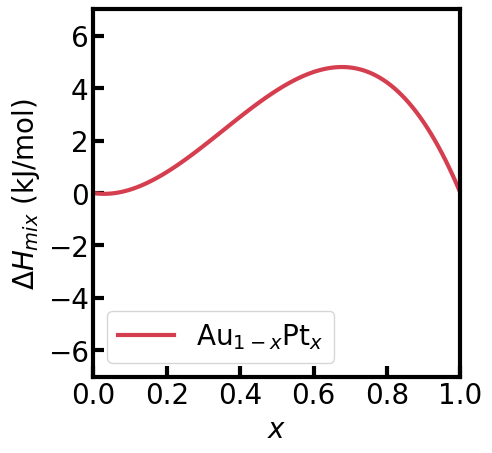

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(1,1, figsize=(5,5))

x = np.linspace(0, 1, 101)

# Configure axis labels and limits
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$\Delta H_{mix}$ (kJ/mol)", fontsize=20)
ax.set_xlim(0,1)
ax.set_ylim(-7,7)
ax.set_xticks(np.linspace(0,1,6))
ax.set_yticks(np.arange(-6,7,2))

# Plot the data
ax.plot(x, enthalpy_of_mixing, color='#d53e4f', linewidth=3, label="Au$_{1-x}$Pt$_{x}$")
ax.legend(loc="best", fontsize=20)

# Customize tick parameters
ax.tick_params(direction='in', axis='both', which='major', labelsize=20, width=3, length=8)
ax.set_box_aspect(1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.tight_layout()
# plt.savefig("aupt_enthalpy_of_mixing.png", dpi=600, format='png', bbox_inches='tight')
plt.show()

In [ ]:
temperatures = np.arange(300, 3001, 5)

df_spinodal = blendpy.get_spinodal_decomposition(temperatures = temperatures, A=0, B=1, npoints = 501)
df_spinodal.to_csv("test_spinodal_AuPt.csv", index=False, header=True, sep=',')

In [11]:
df_binodal = blendpy.get_binodal_curve(temperatures = temperatures, A=0, B=1, npoints=501)
df_binodal.to_csv("test_binodal_AuPt.csv", index=False, header=True, sep=',')

# Phase diagram

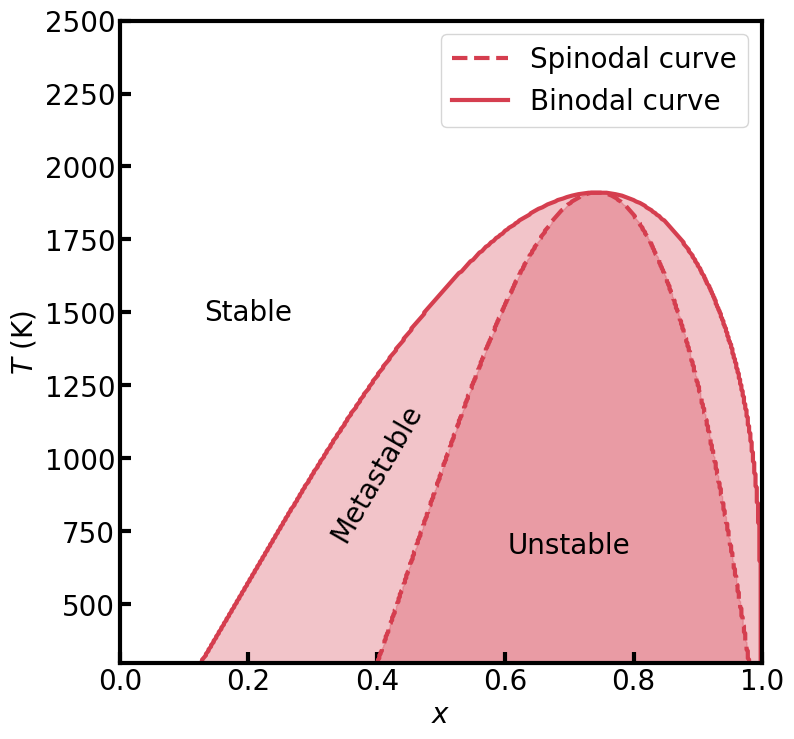

In [26]:
# Plot phase diagram
# df_spinodal = pd.read_csv("test_spinodal_AuPt.csv")
# df_binodal = pd.read_csv("test_binodal_AuPt.csv")

# Create figure and axis
fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(0, 1, 101)

# Configure axis labels and limits
ax.set_xlabel("$x$", fontsize=20)
ax.set_ylabel("$T$ (K)", fontsize=20)
ax.set_xlim(0,1)
ax.set_ylim(300, 2500)
ax.set_xticks(np.linspace(0,1,6))
# ax.set_yticks(np.arange(-6,7,2))

# Plot the data
ax.plot(df_spinodal['x'], df_spinodal['t'], color='#d53e4f', linestyle='--', linewidth=3, label="Spinodal curve")
ax.plot(df_binodal['x'], df_binodal['t'], color='#d53e4f', linewidth=3, label="Binodal curve")

# Fill below the curves with transparency (alpha=0.3 means 30% opacity)
ax.fill_between(df_spinodal['x'], df_spinodal['t'], 300, color='#d53e4f', alpha=0.3)
ax.fill_between(df_binodal['x'], df_binodal['t'], 300, color='#d53e4f', alpha=0.3)
ax.legend(loc="best", fontsize=20)

# Add text annotations
ax.text(0.2, 1500, "Stable", fontsize=20, ha='center', va='center')
ax.text(0.4, 950, "Metastable", fontsize=20, ha='center', va='center', rotation=60)
ax.text(0.7, 700, "Unstable", fontsize=20, ha='center', va='center')

# Customize tick parameters
ax.tick_params(direction='in', axis='both', which='major', labelsize=20, width=3, length=8)
ax.set_box_aspect(1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.tight_layout()
plt.savefig("phase_diagram.png", dpi=600, format='png', bbox_inches='tight')
plt.show()